#Imports

In [ ]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 16.7 MB/s eta 0:00:00


In [ ]:
!pip install torch torchvision

In [ ]:
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.1+cpu.html

!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from torch_geometric.nn import GINConv, global_mean_pool, global_add_pool
from torch_geometric.data import Data, Batch
from torch_geometric.data import DataLoader as GeoDataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

In [ ]:
import torch.nn.functional as F

In [ ]:
from torch_geometric.data import Batch
import json

#Data Preprocessing



In [ ]:
def preprocess_genomic_data(file_path, feature_list):
    genomic_data = pd.read_csv(file_path)

    genomic_data_filtered = genomic_data[feature_list]

    scaler = StandardScaler()
    genomic_data_normalized = scaler.fit_transform(genomic_data_filtered)

    return genomic_data_normalized, scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def smiles_to_graph(smiles, pIC50):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom.GetAtomicNum())

    edge_indices = []
    for bond in mol.GetBonds():
        edge_indices.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        edge_indices.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])

    atom_features = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    data = Data(x=atom_features, edge_index=edge_indices, y=pIC50)
    return data

def preprocess_drug_data(file_path):
    drug_data = pd.read_csv(file_path, sep=',')

    drug_data['pIC50'].fillna(drug_data['pIC50'].mean(), inplace=True)

    scaler = MinMaxScaler()
    drug_data['pIC50'] = scaler.fit_transform(drug_data[['pIC50']])

    drug_graphs = []
    for idx, row in drug_data.iterrows():
        graph = smiles_to_graph(row['SMILES'], row['pIC50'])
        if graph is not None:
            drug_graphs.append(graph)

    return drug_graphs

In [ ]:
class GenomicDataset(Dataset):
    def __init__(self, genomic_data):
        """
        Dataset for genomic data.
        """
        self.genomic_data = genomic_data

    def __len__(self):
        return len(self.genomic_data)

    def __getitem__(self, idx):
        return torch.tensor(self.genomic_data[idx], dtype=torch.float)


class DrugDataset(Dataset):
    def __init__(self, drug_graphs):
        self.drug_graphs = drug_graphs

    def __len__(self):
        return len(self.drug_graphs)

    def __getitem__(self, idx):
        return self.drug_graphs[idx]


def genomic_collate_fn(batch):
    genomic_features = torch.stack(batch)
    return genomic_features


def drug_collate_fn(batch):
    drug_graphs = GeoDataLoader(batch, batch_size=len(batch), shuffle=False)
    return next(iter(drug_graphs))


def create_genomic_dataloader(genomic_data, batch_size=32):
    dataset = GenomicDataset(genomic_data)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=genomic_collate_fn)


def create_drug_dataloader(drug_graphs, batch_size=32):
    dataset = DrugDataset(drug_graphs)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=drug_collate_fn)

In [ ]:
genomic_features = [
        'cn_CEACAM6', 'cn_CD79A', 'cn_ATP1A3', 'cn_KCNN4', 'cn_CBLC',
        'cn_FOSB', 'cn_FOXA3', 'cn_KCNC3', 'cn_SPIB',
        'cn_KLK6', 'cn_KLK7', 'cn_KLK8', 'cn_KLK10', 'cn_KLK11', 'cn_KLK12', 'cn_KLK13', 'cn_KLK14',
        'cn_HAS1', 'cn_NLRP7', 'cn_TNNT1', 'cn_TNNI3', 'cn_SYT5', 'cn_COX6B2',
        'cn_NLRP5', 'cn_PEG3', 'cn_ZSCAN1', 'cn_DEFB132', 'cn_RSPO4',
        'cn_SIRPG', 'cn_TGM3', 'cn_ADAM33', 'cn_SPEF1', 'cn_PRND',
        'cn_CHGB', 'cn_FERMT1', 'cn_PAK7', 'cn_SNAP25', 'cn_FLRT3',
        'cn_PCSK2', 'cn_PTPRT', 'cn_BCAS1', 'cn_CYP24A1', 'cn_BMP7',
        'cn_PCK1', 'cn_ZBP1', 'cn_ZNF831', 'cn_EDN3',
        'mu_ATP10B', 'mu_FAT1', 'mu_FBN3', 'mu_FAT2', 'mu_MTOR',
        'mu_MDN1', 'mu_MXRA5', 'mu_MAP3K1',
        'mu_PTEN', 'mu_PIK3CA', 'mu_PCDH19',
        'mu_PLXNA4', 'mu_PTPRD', 'mu_PLCE1', 'mu_PCNT', 'mu_PCLO',
        'mu_PDE4DIP', 'mu_PKD1L1', 'mu_PCNXL2', 'mu_PRKDC', 'mu_PREX2'
]

genomic_file = "/content/drive/MyDrive/hackwar/genomic_data.csv"
drug_file = "/content/drive/MyDrive/hackwar/drug_data.csv"

genomic_data, genomic_scaler = preprocess_genomic_data(genomic_file, genomic_features)
drug_graphs = preprocess_drug_data(drug_file)
print("Genomic Data Shape:", genomic_data.shape)

batch_size = 64
genomic_dataloader = create_genomic_dataloader(genomic_data, batch_size=batch_size)
drug_dataloader = create_drug_dataloader(drug_graphs, batch_size=batch_size)

for genomic_batch in genomic_dataloader:
    print("Genomic Batch Shape:", genomic_batch.shape)
    break

for drug_batch in drug_dataloader:
    print("Drug Batch:", drug_batch)
    break

<ipython-input-15-d82cef786b20>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  drug_data['pIC50'].fillna(drug_data['pIC50'].mean(), inplace=True)


Genomic Data Shape: (705, 68)
Genomic Batch Shape: torch.Size([64, 68])
Drug Batch: DataBatch(x=[1106, 1], edge_index=[2, 2330], y=[64], batch=[1106], ptr=[65])


#Model Architecture

In [ ]:
class DrugGNN(nn.Module):
    def __init__(self, node_features, hidden_dim):
        super(DrugGNN, self).__init__()
        self.conv1 = GINConv(
            nn.Sequential(
                nn.Linear(node_features, hidden_dim * 2),
                nn.BatchNorm1d(hidden_dim * 2),
                nn.ReLU(),
                nn.Linear(hidden_dim * 2, hidden_dim * 2)
            )
        )
        self.conv2 = GINConv(
            nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim * 2),
                nn.BatchNorm1d(hidden_dim * 2),
                nn.ReLU(),
                nn.Linear(hidden_dim * 2, hidden_dim * 2)
            )
        )
        self.conv3 = GINConv(
            nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
        )

        self.bn1 = nn.BatchNorm1d(hidden_dim * 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        self.dropout = nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)

        attention_weights = self.attention(x)
        attention_weights = torch.softmax(attention_weights, dim=0)
        x = x * attention_weights
        x = global_add_pool(x, batch)

        return x

In [ ]:
class GenomicNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GenomicNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LayerNorm(hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        self.final_layer = nn.Linear(hidden_dim, hidden_dim // 2)

    def forward(self, x):
        return self.layers(x)

In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self, node_features, genomic_dim, hidden_dim=256):
        super(MultiTaskModel, self).__init__()

        self.drug_gnn = DrugGNN(node_features, hidden_dim)
        self.genomic_net = GenomicNet(genomic_dim, hidden_dim)

        self.shared_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim * 2),
                nn.LayerNorm(hidden_dim * 2),
                nn.ReLU(),
                nn.Dropout(0.2)
            ) for _ in range(3)
        ])

        self.drug_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Tanh()
        )

        self.genomic_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Tanh()
        )

    def forward(self, drug_data, genomic_data):
        drug_features = self.drug_gnn(drug_data)
        genomic_features = self.genomic_net(genomic_data)

        combined = torch.cat((drug_features, genomic_features), dim=1)

        x = combined
        for layer in self.shared_layers:
            x = layer(x) + x

        drug_pred = self.drug_head(x)
        genomic_pred = self.genomic_head(x)

        return drug_pred, genomic_pred

#Model Training

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 68])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 1/50, Train Loss: 0.5657, Val Loss: 0.3494
Epoch 2/50, Train Loss: 0.4001, Val Loss: 0.3376
Epoch 3/50, Train Loss: 0.3838, Val Loss: 0.3218
Epoch 4/50, Train Loss: 0.3758, Val Loss: 0.3168
Epoch 5/50, Train Loss: 0.3732, Val Loss: 0.3143
Epoch 6/50, Train Loss: 0.3719, Val Loss: 0.3141
Epoch 7/50, Train Loss: 0.3762, Val Loss: 0.3132
Epoch 8/50, Train Loss: 0.3715, Val Loss: 0.3151
Epoch 9/50, Train Loss: 0.3696, Val Loss: 0.3128
Epoch 10/50, Train Loss: 0.3681, Val Loss: 0.3107
Epoch 11/50, Train Loss: 0.3632, Val Loss: 0.3117
Epoch 12/50, Train Loss: 0.3698, Val Loss: 0.3124
Epoch 13/50, Train Loss: 0.3650, Val Loss: 0.3111
Epoch 14/50, Train Loss: 0.3659, Val Loss: 0.3129
Epoch 15/50, Train Loss: 0.3694, Val Loss: 0.3114
Epoch 16/50, Train Loss: 0.3664, Val Loss: 0.3106
Epoch 17/50, Train Loss: 0.3653, Val Loss: 0.3105
Epoch 18/50, Train Loss: 0.3599, Val Loss: 0.3100
Epoch 19/50, Train Loss: 0.3676, Val Loss: 0.3114
Epoch 20/50, Train Loss: 0.3627, Val Loss: 0.3106
Epoch 21/

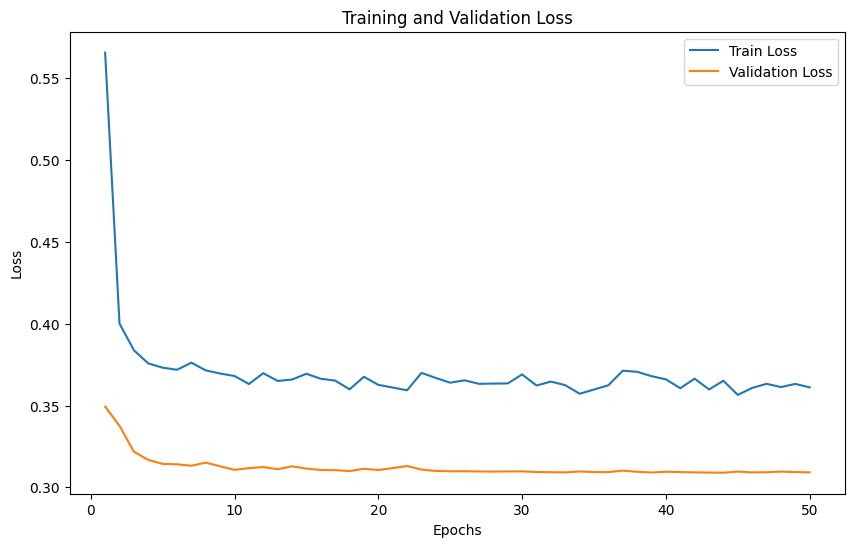

In [ ]:
node_features = drug_graphs[0].x.size(1)
genomic_dim = genomic_data.shape[1]
hidden_dim = 256

model = MultiTaskModel(node_features=node_features, genomic_dim=genomic_dim, hidden_dim=hidden_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

drug_criterion = nn.MSELoss()
genomic_criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

def split_dataloader(dataloader, split_ratios):
    dataset = dataloader.dataset
    train_len = int(split_ratios[0] * len(dataset))
    val_len = int(split_ratios[1] * len(dataset))
    test_len = len(dataset) - train_len - val_len
    train_data, val_data, test_data = random_split(dataset, [train_len, val_len, test_len])

    train_loader = GeoDataLoader(train_data, batch_size=dataloader.batch_size, shuffle=True)
    val_loader = GeoDataLoader(val_data, batch_size=dataloader.batch_size, shuffle=False)
    test_loader = GeoDataLoader(test_data, batch_size=dataloader.batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

genomic_train_loader, genomic_val_loader, genomic_test_loader = split_dataloader(genomic_dataloader, [0.7, 0.15, 0.15])
drug_train_loader, drug_val_loader, drug_test_loader = split_dataloader(drug_dataloader, [0.7, 0.15, 0.15])

import matplotlib.pyplot as plt

def train_and_validate(model, genomic_train_loader, drug_train_loader, genomic_val_loader, drug_val_loader, device, num_epochs):
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    drug_criterion = nn.MSELoss()
    genomic_criterion = nn.MSELoss()

    best_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch_idx, (genomic_batch, drug_batch) in enumerate(zip(genomic_train_loader, drug_train_loader)):
            batch_size = min(genomic_batch.size(0), drug_batch.size(0))
            genomic_batch = genomic_batch[:batch_size].to(device)
            drug_batch = Batch.from_data_list(drug_batch[:batch_size]).to(device)

            optimizer.zero_grad()

            drug_pred, genomic_pred = model(drug_batch, genomic_batch)

            drug_loss = drug_criterion(drug_pred, drug_batch.y)
            genomic_loss = genomic_criterion(genomic_pred, genomic_batch)

            loss = drug_loss * 0.6 + genomic_loss * 0.4

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(genomic_train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for genomic_batch, drug_batch in zip(genomic_val_loader, drug_val_loader):
                batch_size = min(genomic_batch.size(0), drug_batch.size(0))
                genomic_batch = genomic_batch[:batch_size].to(device)
                drug_batch = Batch.from_data_list(drug_batch[:batch_size]).to(device)

                drug_pred, genomic_pred = model(drug_batch, genomic_batch)

                drug_loss = drug_criterion(drug_pred, drug_batch.y)
                genomic_loss = genomic_criterion(genomic_pred, genomic_batch)
                loss = drug_loss * 0.6 + genomic_loss * 0.4
                val_loss += loss.item()

        avg_val_loss = val_loss / len(genomic_val_loader)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}")

    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

train_and_validate(model, genomic_train_loader, drug_train_loader, genomic_val_loader, drug_val_loader, device, num_epochs=50)

In [ ]:
def test(model, genomic_loader, drug_loader, device):
    total_drug_loss = 0
    total_genomic_loss = 0
    total_batches = 0
    model.eval()
    with torch.no_grad():
        for genomic_batch, drug_batch in zip(genomic_loader, drug_loader):
            batch_size = min(genomic_batch.size(0), drug_batch.size(0))
            genomic_batch = genomic_batch[:batch_size]
            drug_batch = drug_batch[:batch_size]
            genomic_batch = genomic_batch.to(device)

            if isinstance(drug_batch, Batch):
                drug_batch = drug_batch.to(device)
            else:
                drug_batch = Batch.from_data_list([data for data in drug_batch]).to(device)

            drug_pred, genomic_pred = model(drug_batch, genomic_batch)
            drug_labels = drug_batch.y
            genomic_labels = genomic_batch

            drug_loss = drug_criterion(drug_pred, drug_labels)
            genomic_loss = genomic_criterion(genomic_pred, genomic_labels)

            total_drug_loss += drug_loss.item()
            total_genomic_loss += genomic_loss.item()
            total_batches += 1

            print(f"Batch {total_batches}:")
            print("Drug Loss:", drug_loss.item())
            print("Genomic Loss:", genomic_loss.item())
    avg_drug_loss = total_drug_loss / total_batches
    avg_genomic_loss = total_genomic_loss / total_batches
    print("\nTest Results:")
    print(f"Average Drug Loss: {avg_drug_loss:.4f}")
    print(f"Average Genomic Loss: {avg_genomic_loss:.4f}")

test(model, genomic_test_loader, drug_test_loader, device)

Batch 1:
Drug Loss: 0.07730662077665329
Genomic Loss: 0.273873895406723
Batch 2:
Drug Loss: 0.046660441905260086
Genomic Loss: 0.2630455791950226

Test Results:
Average Drug Loss: 0.0620
Average Genomic Loss: 0.2685


#Save model and data

In [ ]:
torch.save(model, 'model.pth')

In [ ]:
torch.save(drug_graphs, 'data.pt')

#Prediction

In [ ]:
def predict_single_patient(model, patient_genomic_data, drug_graphs, genomic_features, device, drug_data):
    patient_data, _ = preprocess_genomic_data(patient_genomic_data, genomic_features)

    results = []

    model.eval()

    with torch.no_grad():
        patient_tensor = torch.tensor(patient_data[0], dtype=torch.float).unsqueeze(0).to(device)
        for idx, drug_graph in enumerate(drug_graphs):
            drug_batch = Batch.from_data_list([drug_graph]).to(device)
            drug_pred, genomic_pred = model(drug_batch, patient_tensor)

            compatibility_score = round(torch.tanh(drug_pred).item(), 3)
            toxicity_score = round(torch.tanh(genomic_pred).item(), 3)

            confidence_score = round((abs(compatibility_score) + abs(toxicity_score)) / 2, 3)

            normalized_toxicity = round(-toxicity_score, 3)

            overall_score = round(
                compatibility_score * 0.4 +
                normalized_toxicity * 0.3 +
                confidence_score * 0.3, 3
            )

            recommended = (compatibility_score > 0.03) and (toxicity_score < -0.03)

            results.append({
                'drug_id': idx,
                'drug_name': drug_data.iloc[idx]['SMILES'],
                'compatibility_score': compatibility_score,
                'toxicity_score': toxicity_score,
                'confidence_score': confidence_score,
                'overall_score': overall_score,
                'recommended': recommended
            })

    results_df = pd.DataFrame(results)

    recommended = results_df[results_df['recommended']].nlargest(5, 'overall_score')

    avoid = results_df[~results_df['recommended']].nlargest(5, 'overall_score')

    combined_json = {
        "drug_analysis": {
            "best": recommended.to_dict(orient='records'),
            "worst": avoid.to_dict(orient='records')
        }
    }

    print("\n=== TOP 5 RECOMMENDED DRUGS ===")
    print("--------------------------------")
    for _, drug in recommended.iterrows():
        print(f"Drug ID: {drug['drug_id']}")
        print(f"SMILES: {drug['drug_name']}")
        print(f"Compatibility Score: {drug['compatibility_score']:.3f} (-1 to 1)")
        print(f"Toxicity Score: {drug['toxicity_score']:.3f} (-1 to 1)")
        print(f"Confidence Score: {drug['confidence_score']:.3f} (0 to 1)")
        print(f"Overall Score: {drug['overall_score']:.3f}")
        print("--------------------------------")
    print()

    print("\n=== TOP 5 DRUGS TO AVOID ===")
    print("--------------------------------")
    for _, drug in avoid.iterrows():
        print(f"Drug ID: {drug['drug_id']}")
        print(f"SMILES: {drug['drug_name']}")
        print(f"Compatibility Score: {drug['compatibility_score']:.3f} (-1 to 1)")
        print(f"Toxicity Score: {drug['toxicity_score']:.3f} (-1 to 1)")
        print(f"Confidence Score: {drug['confidence_score']:.3f} (0 to 1)")
        print(f"Overall Score: {drug['overall_score']:.3f}")
        print("--------------------------------")
    print()

    return combined_json

In [ ]:
model = torch.load('/content/drive/MyDrive/hackwar/model.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
loaded_data = torch.load('data.pt')

patient_file = "/content/drive/MyDrive/hackwar/test.csv"

drug_database = "/content/drive/MyDrive/hackwar/drug_data.csv"
drug_data = pd.read_csv(drug_database)

output = predict_single_patient(
    model=model,
    patient_genomic_data=patient_file,
    drug_graphs=loaded_data,
    genomic_features=genomic_features,
    device=device,
    drug_data=drug_data
)

<ipython-input-31-a98afc502980>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/hackwar/model.pth')
<ipython-input-31-a98afc50298


=== TOP 5 RECOMMENDED DRUGS ===
--------------------------------
Drug ID: 15051
SMILES: CCCCCI
Compatibility Score: 0.096 (-1 to 1)
Toxicity Score: -0.087 (-1 to 1)
Confidence Score: 0.091 (0 to 1)
Overall Score: 0.092
--------------------------------
Drug ID: 3366
SMILES: O=C(O)c1cc(I)cc(I)c1O
Compatibility Score: 0.097 (-1 to 1)
Toxicity Score: -0.084 (-1 to 1)
Confidence Score: 0.090 (0 to 1)
Overall Score: 0.091
--------------------------------
Drug ID: 4003
SMILES: Nc1ccc(I)cc1
Compatibility Score: 0.097 (-1 to 1)
Toxicity Score: -0.083 (-1 to 1)
Confidence Score: 0.090 (0 to 1)
Overall Score: 0.091
--------------------------------
Drug ID: 4468
SMILES: Nc1cccc(I)c1
Compatibility Score: 0.097 (-1 to 1)
Toxicity Score: -0.083 (-1 to 1)
Confidence Score: 0.090 (0 to 1)
Overall Score: 0.091
--------------------------------
Drug ID: 4469
SMILES: Oc1cccc(I)c1
Compatibility Score: 0.097 (-1 to 1)
Toxicity Score: -0.083 (-1 to 1)
Confidence Score: 0.090 (0 to 1)
Overall Score: 0.091
---

In [ ]:
print(json.dumps(output, indent=4))

{
    "drug_analysis": {
        "best": [
            {
                "drug_id": 15051,
                "drug_name": "CCCCCI",
                "compatibility_score": 0.096,
                "toxicity_score": -0.087,
                "confidence_score": 0.091,
                "overall_score": 0.092,
                "recommended": true
            },
            {
                "drug_id": 3366,
                "drug_name": "O=C(O)c1cc(I)cc(I)c1O",
                "compatibility_score": 0.097,
                "toxicity_score": -0.084,
                "confidence_score": 0.09,
                "overall_score": 0.091,
                "recommended": true
            },
            {
                "drug_id": 4003,
                "drug_name": "Nc1ccc(I)cc1",
                "compatibility_score": 0.097,
                "toxicity_score": -0.083,
                "confidence_score": 0.09,
                "overall_score": 0.091,
                "recommended": true
            },
            {